# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 6 y 7

### **Modelado de Tópicos - LSI/LDA**

#### **Nombres y matrículas de los integrantes del equipo:**
Equipo 9:

Yohanna Ceballos Salomón  | A01795115

Mauricio Castilo Galindo  | A01795453

Juan Manuel Carballo M.   | A01166758

Andrea Cantú Martínez     | A01235000

Armando Cerda De La Rosa  | A01570376

In [ ]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import os

import re
import string
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')

!pip install spacy download es_core_news_sm
import spacy
nlp = spacy.load("es_core_news_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

!pip install scipy --upgrade --user
!pip install gensim --upgrade --user
!pip install numpy --upgrade --user
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 728.8 kB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: typer
    Found existing installation: typer 0.9.4
    Uninstalling typer-0.9.4:
      Successfully uninstalled typer-0.9.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.1
    Uninstalling pydantic-2.7.1:
      Successfully uninstalled pydantic-2.7.1
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.3
    Uninstalling thinc-8.2.3:
      Successfully uninstall

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pregunta 1
Descarga el archivo **noticiasTopicModeling.txt** que se encuentra en Canvas.

Este archivo consiste en **5658 noticias** de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:

[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]

Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia.

En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados.

**Carga dicho archivo y genera un DataFrame de Pandas llamado “df”** y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MNA/Procesamiento de Lenguaje Natural/noticiasTopicModeling.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extraer los cuerpos de las noticias y crear el DataFrame
noticias = [item['texto'] for item in data]
df = pd.DataFrame(noticias, columns=['noticia'])

In [ ]:
df.head()

,noticia
0,"""España ha dejado de ser católica"", decía Manu..."
1,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno ha alegado la suspensión de plazos...
3,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,Panamá debe entregar esta semana a la Corte In...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   noticia  5658 non-null   object
dtypes: object(1)
memory usage: 44.3+ KB


In [ ]:
# Creamos una copia de la serie de strings
X = df.noticia.copy()
# Verificamos que tenemos la dimensiones esperadas
assert X.shape == (5658,)

# Pregunta 2
Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español.

Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la distribución de cada tema.

NOTA: Recuerda que esta es una técnica no supervisada, por lo que no requerimos hacer una partición de los datos.

In [ ]:
# Obtener stop words en Español
stop_words = set(stopwords.words('spanish'))
# Adicionar palabras adicionales que no aportan
# valor según la lectura de varias noticias (se puede agregar más)
word_lst = ['etiquetas', 'según', 'ser', 'ahora', 'así', 'toda',
            'sido', 'además', 'después', 'solo', 'aunque', 'hace',
            'puede', 'podría', 'pudo', 'vez', 'hacer', 'mismo',
            'días', 'día', 'tras', 'cada', 'tres', 'dos'
            ]
# Actualizar conjunto de palabras de stop_words
stop_words.update(word_lst)
print("Longitud de stop_words:", len(stop_words))
print(stop_words)

def clean_tok(doc):
    # Poner todo en minúsculas
    tokens = doc.lower()
    # Usar solo caracteres alfabéticos, tomando en cuenta ñ y acentos
    tokens = re.sub(r'[^a-zñáéíóúü\s]', '  ', tokens)
    tokens = re.sub(r'[\s]{2,}', ' ', tokens)
    tokens = tokens.strip()
    # Tokenizar, eliminar palabras muy cortas y stopwords
    tokens = [word for word in tokens.split() if (len(word) > 2) & (word not in stop_words)]
    tokens = ' '.join(tokens)
    # Aplicar lemma a las palabras diferentes a verbos
    tokens = list(set([word.lemma_ for word in nlp(tokens) if word.pos_ != 'VERB']))
    # Eliminar duplicados, stopwords después de lemma y palabras muy cortas
    tokens = [word for word in tokens if word not in stop_words]
    tokens = list(set([word for word in tokens if len(word) > 2]))

    return tokens

# Aplicar el proceso de limpieza y tokenización
Xclean = [clean_tok(x) for x in X]
# Excluir cualquier noticia que resulte vacía
Xclean = [news for news in Xclean if news]

print("\nLongitud de Xclean:", len(Xclean))

Longitud de stop_words: 337
{'estuvierais', 'cual', 'los', 'tendrás', 'sin', 'desde', 'son', 'hubieseis', 'nos', 'hubiese', 'nuestra', 'después', 'antes', 'unos', 'que', 'habrás', 'estará', 'otras', 'fuimos', 'seré', 'eras', 'hemos', 'hayáis', 'tuvisteis', 'tuvieron', 'estés', 'sentidas', 'seas', 'tras', 'siente', 'tendremos', 'habíais', 'tendría', 'estuviera', 'porque', 'tienen', 'teníais', 'sí', 'a', 'estarás', 'sintiendo', 'sentid', 'un', 'aunque', 'fuerais', 'ella', 'estamos', 'les', 'las', 'había', 'pero', 'habidos', 'estéis', 'ahora', 'tenemos', 'hubimos', 'entre', 'mía', 'hubieses', 'serás', 'tuvieseis', 'día', 'hubiesen', 'ya', 'durante', 'se', 'tenidos', 'tenga', 'vosotros', 'al', 'seáis', 'tuvieran', 'quien', 'está', 'pudo', 'donde', 'sería', 'estuviéramos', 'estáis', 'hubisteis', 'serías', 'según', 'tenido', 'hubiera', 'habrías', 'nada', 'estaremos', 'fue', 'fueron', 'estemos', 'seremos', 'vosotras', 'suyas', 'toda', 'estabais', 'vuestra', 'habían', 'una', 'estada', 'habría'

In [ ]:
# Despleguemos las primeras noticias después del proceso de limpieza:

for x in Xclean[50:55]:
  print(x)

['licencia', 'municipal', 'licencio', 'lado', 'situado', 'establecido', 'zona', 'capital', 'sanidad', 'actuación', 'pabellón', 'dado', 'local', 'polizia', 'través', 'coronavirus', 'explicado', 'medida', 'extintor', 'julio', 'vía', 'aragón', 'euskadi', 'aranzabal', 'alavés', 'infracción', 'clausurado', 'denuncia', 'vasco', 'protección', 'interpuesto', 'total', 'calle', 'tarde', 'gobierno', 'covid', 'requerido', 'mascarilla', 'guardia', 'obligado', 'policía', 'portal', 'social', 'incendio', 'actividad', 'lonja', 'joven', 'visto', 'señal', 'noche', 'sábado', 'urbana', 'evacuación', 'red', 'policia', 'dictado', 'salud', 'normativo', 'vitoria', 'fiesta', 'persona']
['moncloa', 'caso', 'menos', 'valor', 'queja', 'completado', 'corriente', 'suscrito', 'final', 'activado', 'ciudadano', 'pesar', 'previsión', 'plazo', 'audito', 'pacto', 'unidas', 'medio', 'autoevalúa', 'político', 'ejecutivo', 'ambos', 'tampoco', 'efe', 'formación', 'presidente', 'pablo', 'actúo', 'gestión', 'conseguido', 'parte

# PARTE 1

# Pregunta 3

Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?


*   **Cada renglón:** Representa una noticia del conjunto de datos. En la matriz TF-IDF, cada renglón corresponde a un documento (en este caso, una noticia).

*   **Cada columna:** Representa un token (palabra) que aparece en las noticias después del proceso de limpieza y tokenización. Las columnas contienen los valores TF-IDF para cada token en cada noticia.

*   **Valores de la matriz:** El valor en la posición (𝑖,𝑗) de la matriz TF-IDF indica la importancia del token 𝑗 en la noticia 𝑖. Un valor más alto significa que el token es más relevante para esa noticia en comparación con otras noticias en el conjunto de datos.




In [ ]:
# Generar vocabulario
from collections import Counter

midiccionario = Counter()

for k in range(len(Xclean)):
  midiccionario.update(Xclean[k])


print('Longitud del diccionario:', len(midiccionario))
print('\n(word,frequency):')
print(midiccionario.most_common(30))

Longitud del diccionario: 65688

(word,frequency):
[('poder', 4096), ('año', 3496), ('parte', 3153), ('primero', 3151), ('último', 3068), ('gobierno', 3056), ('caso', 3040), ('nuevo', 2981), ('político', 2764), ('persona', 2728), ('público', 2691), ('medio', 2672), ('momento', 2535), ('pasado', 2533), ('hecho', 2479), ('deber', 2348), ('españa', 2186), ('país', 2166), ('socio', 2149), ('mes', 2118), ('trabajo', 2060), ('mayor', 2044), ('semana', 2042), ('menos', 2033), ('sociedad', 1995), ('social', 1977), ('eldiario', 1968), ('situación', 1929), ('tiempo', 1874), ('general', 1868)]


In [ ]:
# Definir la frecuencia mínima para crear el nuevo vocabulario con el tamaño propuesto
min_freq = 10

midicc = midiccionario.copy()
for key, value in midiccionario.items():
  if value < min_freq:
    midicc.pop(key)

print("Nueva longitud del nuevo vocabulario:", len(midicc))
print("\n Algunos elementos del diccionario:", list(midicc.items())[0:5])
print("\n 10 palabras más comúnes:", midicc.most_common(10))

Nueva longitud del nuevo vocabulario: 10951

 Algunos elementos del diccionario: [('derecha', 257), ('bastante', 412), ('escisión', 25), ('popular', 859), ('tal', 961)]

 10 palabras más comúnes: [('poder', 4096), ('año', 3496), ('parte', 3153), ('primero', 3151), ('último', 3068), ('gobierno', 3056), ('caso', 3040), ('nuevo', 2981), ('político', 2764), ('persona', 2728)]


In [ ]:
# Filtrar con respecto al nuevo vocabulario propuesto:
train_x = []
for ss in Xclean:
  train_x.append([w for w in ss if w in midicc])

# Podemos ver algunos de los comentarios, antes y después
# de incluir la condición de la frecuencia mínima de ocurrencia de un token:
for k in range(3):
  print('Antes:', Xclean[k])
  print('Después:', train_x[k])
  print("\n")

Antes: ['derecha', 'bastante', 'escisión', 'popular', 'tal', 'víktor', 'amplio', 'excepcional', 'papel', 'suecia', 'menos', 'extremo', 'propio', 'portugal', 'amigo', 'santiago', 'polaco', 'pis', 'último', 'efecto', 'migración', 'actor', 'grecia', 'cosa', 'clásico', 'vox', 'internacional', 'fundamental', 'parlamento', 'grupo', 'irrupción', 'financiación', 'república', 'ciudadano', 'crisis', 'marine', 'gobernante', 'cama', 'ruso', 'españa', 'segundo', 'nuevo', 'domingo', 'eje', 'nunca', 'medio', 'griego', 'ley', 'cierto', 'existido', 'dictador', 'harakiri', 'tiempos', 'duplico', 'aquel', 'mantuviera', 'parlamentario', 'escaño', 'suspendido', 'parte', 'solución', 'gobierno', 'fascismo', 'autonómico', 'azaña', 'nacional', 'geert', 'llegado', 'número', 'aun', 'ecr', 'católico', 'europa', 'potencia', 'pen', 'polarización', 'programa', 'congreso', 'encima', 'pueblo', 'julio', 'auroro', 'alemania', 'año', 'precisamente', 'setenta', 'elección', 'país', 'cuyo', 'local', 'incluso', 'legislativa',

In [ ]:
# Obtener las matrices de conteo document-term-matrix como matrices dispersas (sparse matrices).
# Para ello requerimos que cada comentario esté como un solo string.
train_x_docs = []
for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

# Verifica que los primeros comentarios están cada uno como un solo string:
for k in range(5):
  print(train_x_docs[k])

derecha bastante escisión popular tal amplio excepcional papel suecia menos extremo propio portugal amigo santiago polaco último efecto migración actor grecia cosa clásico vox internacional fundamental parlamento grupo irrupción financiación república ciudadano crisis marine gobernante cama ruso españa segundo nuevo domingo eje nunca medio griego ley cierto existido dictador tiempos duplico aquel parlamentario escaño suspendido parte solución gobierno fascismo autonómico nacional llegado número aun católico europa potencia pen polarización programa congreso encima pueblo julio auroro alemania año precisamente setenta elección país cuyo local incluso debajo aún reforma corte voto mayo fuerza alemán décimo demócrata excepción sociológico húngaro mes manuel septiembre alianza ejemplo fascista largo finlandés austriaco democrático noviembre mediados régimen partido italia catalunya sino comienzo europeo integración superior búnker punto muerto fenómeno mejor holandés franquismo europea met

In [ ]:
# Crear el objeto TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=list(midicc.keys()),
                             norm='l2')
# Ajustar el modelo y transformar las noticias a una matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(train_x_docs)

# Crear un DataFrame a partir de la matriz TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Mostrar los primeros 5 renglones con algunas de sus columnas
print(tfidf_df.iloc[:5, :10])  # Despliega los primeros 5 renglones y las primeras 10 columnas


    derecha  bastante  escisión   popular       tal   amplio  excepcional  \
0  0.079202  0.070086  0.123667  0.055874  0.053703  0.07248     0.077686   
1  0.052324  0.000000  0.000000  0.036913  0.035478  0.00000     0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.059159  0.00000     0.000000   
3  0.000000  0.041834  0.000000  0.033351  0.000000  0.00000     0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000     0.000000   

      papel    suecia     menos  
0  0.057816  0.105039  0.039195  
1  0.000000  0.000000  0.025894  
2  0.000000  0.000000  0.043177  
3  0.034510  0.000000  0.023395  
4  0.000000  0.000000  0.038675  


# Pregunta 4

Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.


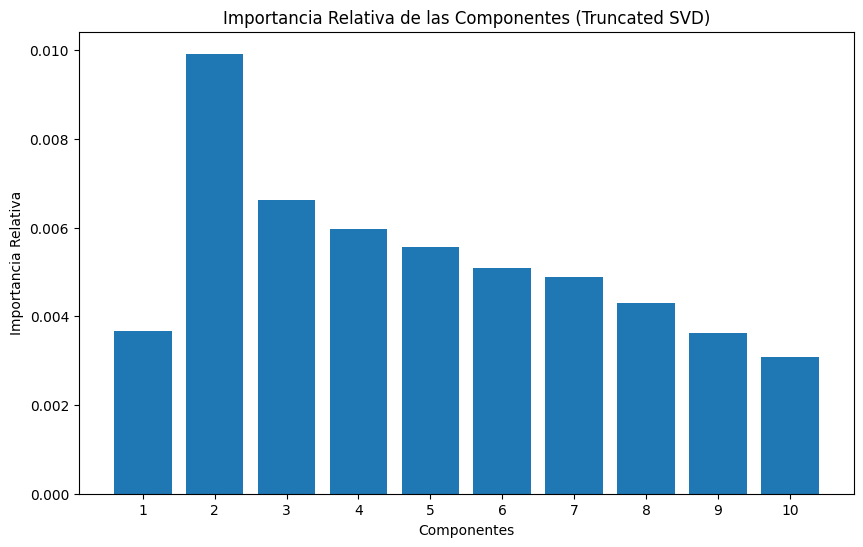

In [ ]:
# Crear el objeto TruncatedSVD
svd = TruncatedSVD(n_components=10,
                   random_state=42
                   )
# Ajustar el modelo y transformar la matriz TF-IDF
tfidf_svd_matrix = svd.fit_transform(tfidf_matrix)

# Obtener la importancia relativa de cada componente
explained_variance = svd.explained_variance_ratio_

# Crear el gráfico de barras de la importancia relativa de las componentes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance, align='center')
plt.xlabel('Componentes')
plt.ylabel('Importancia Relativa')
plt.title('Importancia Relativa de las Componentes (Truncated SVD)')
plt.xticks(range(1, 11))
plt.show()


# Pregunta 5

Obtener la matriz tokens-temas (term-topic) a partir de la matriz V-transpuesta de la descomposición SVD.

Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [ ]:
term_topic_matrix = svd.components_.T

term_topic_df = pd.DataFrame(term_topic_matrix, index=vectorizer.get_feature_names_out(), columns=[f'Tema {i+1}' for i in range(term_topic_matrix.shape[1])])

print(term_topic_df.head())

            Tema 1    Tema 2    Tema 3    Tema 4    Tema 5    Tema 6  \
derecha   0.013710 -0.019760  0.011453  0.007844  0.012897 -0.038453   
bastante  0.018567 -0.004072 -0.029281  0.008783 -0.007530 -0.005986   
escisión  0.002056 -0.003133  0.003762 -0.000026  0.000675 -0.005236   
popular   0.032880 -0.048010  0.045122  0.014428  0.029400 -0.014525   
tal       0.034391 -0.019518 -0.011841  0.011001  0.000266  0.001736   

            Tema 7    Tema 8    Tema 9   Tema 10  
derecha   0.028300 -0.032942 -0.012576  0.012539  
bastante  0.013841 -0.006184  0.019763  0.025064  
escisión  0.005924 -0.003480 -0.002954  0.003282  
popular   0.025007 -0.040686 -0.016968  0.025713  
tal      -0.001411  0.010123  0.022216  0.005972  


# Pregunta 6

Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes.

¿Cómo describirías cada uno de dichos conceptos latentes?

 * Tema 1: Política
 * Tema 2: Covid/Salud/Pandemia Local
 * Tema 3: Covid/Salud/Pandemia Global
 * Tema 4: Actualidad
 * Tema 5: Consultas
 * Tema 6: Legal
 * Tema 7: Sociales
 * Tema 8: Economía/Negocios
 * Tema 9: Educación
 * Tema 10: Post-Pandemia/Covid

¿Se identifican claramente las temáticas de cada uno de ellos?


No realmente, están muy similares entre sí



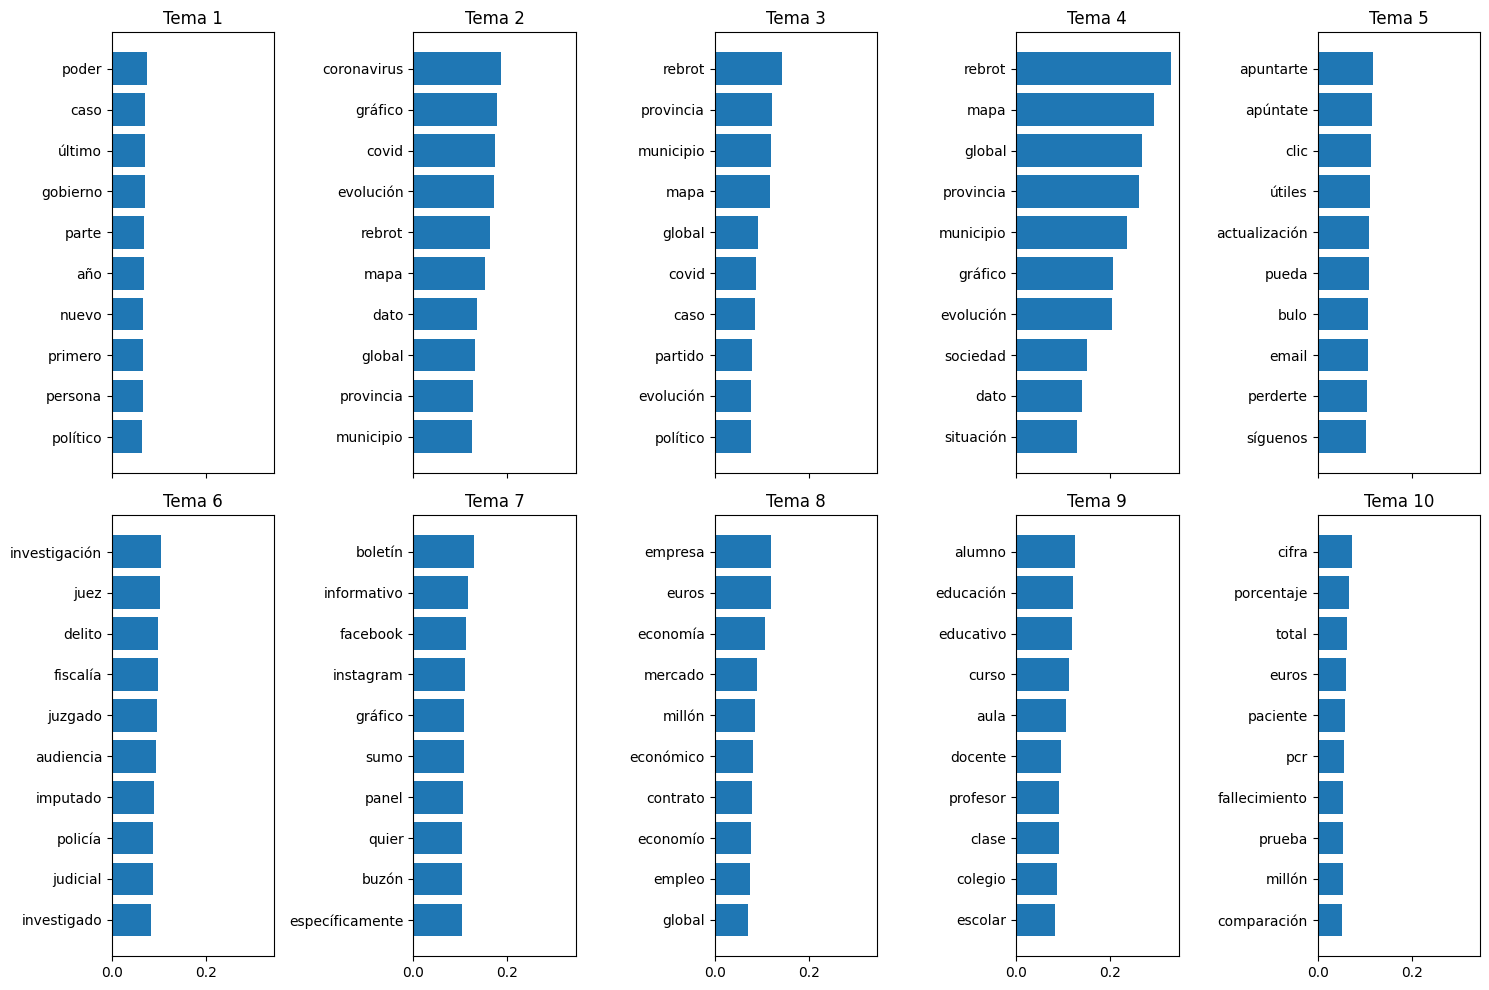

Tema 1: poder, caso, último, gobierno, parte, año, nuevo, primero, persona, político
Tema 2: coronavirus, gráfico, covid, evolución, rebrot, mapa, dato, global, provincia, municipio
Tema 3: rebrot, provincia, municipio, mapa, global, covid, caso, partido, evolución, político
Tema 4: rebrot, mapa, global, provincia, municipio, gráfico, evolución, sociedad, dato, situación
Tema 5: apuntarte, apúntate, clic, útiles, actualización, pueda, bulo, email, perderte, síguenos
Tema 6: investigación, juez, delito, fiscalía, juzgado, audiencia, imputado, policía, judicial, investigado
Tema 7: boletín, informativo, facebook, instagram, gráfico, sumo, panel, quier, buzón, específicamente
Tema 8: empresa, euros, economía, mercado, millón, económico, contrato, economío, empleo, global
Tema 9: alumno, educación, educativo, curso, aula, docente, profesor, clase, colegio, escolar
Tema 10: cifra, porcentaje, total, euros, paciente, pcr, fallecimiento, prueba, millón, comparación


In [ ]:
def get_top_terms_per_topic(components, feature_names, n=10):
    top_terms = {}
    for topic_idx, topic in enumerate(components):
        top_features_idx = topic.argsort()[-n:][::-1]
        top_features = [feature_names[i] for i in top_features_idx]
        top_terms[f'Tema {topic_idx + 1}'] = top_features
    return top_terms

def plot_top_terms(top_terms):
    num_topics = len(top_terms)
    fig, axes = plt.subplots(2, num_topics // 2, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i, (topic, terms) in enumerate(top_terms.items()):
        weights = svd.components_[i, [feature_names.tolist().index(term) for term in terms]]
        axes[i].barh(terms, weights)
        axes[i].set_title(topic)
        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

feature_names = vectorizer.get_feature_names_out()
top_terms = get_top_terms_per_topic(svd.components_, feature_names, n=10)
plot_top_terms(top_terms)

for topic, terms in top_terms.items():
    print(f"{topic}: {', '.join(terms)}")

# PARTE 2

# Pregunta 7

Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación
correspondiente y aplica de preferencia el modelo paralelizable:
https://radimrehurek.com/gensim/models/ldamodel.html
https://radimrehurek.com/gensim/models/ldamulticore.html


In [ ]:
# Generar el diccionario y el corpus:
id2word = corpora.Dictionary(train_x)
corpus = [id2word.doc2bow(doc) for doc in train_x]

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,      # total de tópicos que deseas buscar
                                       chunksize=50,       # número de documentos a analizar en cada chunk de entrenamiento
                                       passes=10,          # número de pasadas al corpus durante el entrenamiento.
                                       alpha=0.2,          # alfa: similaridad document-topics
                                       eta=0.2,            # beta: similaridad topic-words
                                       random_state=7
                                       )
# Veamos la manera en que se distribuyen los términos en cada tópico generado:
for topic_num, words in lda_model.print_topics(num_words=10):
    print('Palabras en Tema {}: {}.'.format(topic_num+1, words))

Palabras en Tema 1: 0.006*"gobierno" + 0.005*"público" + 0.005*"comunidad" + 0.005*"poder" + 0.005*"social" + 0.005*"medida" + 0.004*"nuevo" + 0.004*"laboral" + 0.004*"año" + 0.004*"situación".
Palabras en Tema 2: 0.006*"millón" + 0.005*"empresa" + 0.005*"proyecto" + 0.005*"económico" + 0.005*"mercado" + 0.005*"año" + 0.005*"economía" + 0.005*"inversión" + 0.005*"principal" + 0.004*"grande".
Palabras en Tema 3: 0.007*"político" + 0.006*"gobierno" + 0.005*"deber" + 0.005*"derecho" + 0.005*"presidente" + 0.005*"poder" + 0.004*"acuerdo" + 0.004*"decisión" + 0.004*"país" + 0.004*"dicho".
Palabras en Tema 4: 0.004*"persona" + 0.004*"poder" + 0.004*"problema" + 0.004*"casa" + 0.004*"centro" + 0.003*"uso" + 0.003*"espacio" + 0.003*"tiempo" + 0.003*"distancia" + 0.003*"deber".
Palabras en Tema 5: 0.006*"investigación" + 0.006*"judicial" + 0.005*"juez" + 0.005*"caso" + 0.005*"delito" + 0.004*"policía" + 0.004*"político" + 0.004*"año" + 0.004*"informe" + 0.004*"información".
Palabras en Tema 6: 

# Pregunta 8

Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada?
> Según los resultados de la pregunta 7, podemos clasificar entre 6 y 7 tópicos tales como Economía (tema 2), Cultura (tema 6), Salud (tema 9), Política (tema 3, 7 y 8), Internacional (tema 10), Judicial (tema 5) y Social (tema 1 y 4). Muchos de los anteriores no tienen una fuerte coherencia entre el conjunto de palabras que se obtuvieron por lo que es posible incluso reducir a menos tópicos.

Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias?
> Al igual que LSI, LDA tiene unos tópicos muy bien definidos mientas que otros no parecieran tener alta coherencia. Sin embargo, lo que si tienen en común es que 10 tópicos es un valor alto para clasificar los temas. También observamos, que aunque se habla de los mismo temas, LSI tiene otras palabras relacionadas también al mismo tópico, por ejemplo en LDA nunca aparecen el nombre de aplicaciones tales como Facebook, Instagram o email. Por otro lado, la convergencia de LSI es mucho más rápida que LDA.

¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=train_x,
                                     dictionary=id2word,
                                     coherence='c_v',
                                     window_size=3,
                                     topn=10
                                     )

coherence_lda = coherence_model_lda.get_coherence()

print('Coherencia: ', coherence_lda)

Coherencia:  0.5198579055290374


In [ ]:
def valores_de_coherencia(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
      model = gensim.models.LdaMulticore(corpus=corpus,
                                         id2word=id2word,
                                         num_topics=num_topics,      # total de tópicos que deseas buscar...
                                         chunksize=10,               # número de documentos a analizar en cada chunk de entrenamiento
                                         passes=10,                  # número de pasadas al corpus durante el entrenamiento.
                                         alpha=0.15,                 # alfa: similaridad document-topics
                                         eta=0.15,                   # beta: similaridad topic-words
                                         random_state=7
                                         )


      model_list.append(model)


      coherencemodel = CoherenceModel(model=model,
                                      texts=texts,
                                      dictionary=dictionary,
                                      coherence='c_v',
                                      window_size=3,
                                      topn=3)

      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

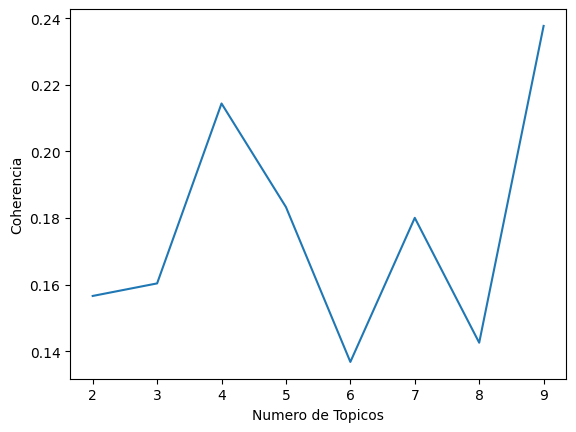

In [ ]:
start=2
limit=10
step=1

model_list, coherence_values = valores_de_coherencia(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=train_x,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Numero de Topicos")
plt.ylabel("Coherencia")
plt.show()

> Tendiendo en cuenta el modelo de coherencia para LDA con "c_v", que se refiere a la coherencia de los temas basada en la medida de la ventana de co-ocurrencia, con un tamaño de ventana de 3 y 10 como el número de términos principales en cada tema que se consideran al calcular la coherencia. Nos da como resultado dos picos, uno en 4 y otro en 9. Dado el análisis previo de las preguntas anteriores, consideramos que **4 podría ser un valor de tópicos adecuados a considerar.**

# Pregunta 9

Dadas las actividades de esta entrega iniciamos con la limpieza de los documentos en idioma Español de los cuales no eliminan ciertos caracteres como tildes o acentos que podrían causar mayores problemas más adelante y la eliminación de palabras como stopwords usando librerias como nltk y spacy, a continuación se creó una matriz TF-IDF la cual nos proporciona una base sólida para aplicar las técnicas no supervisadas LSI y LDA por sus siglas en inglés Latent Semantic Indexing y Latent Dirichlet Allocation.

Tanto LSI y LDA se ocupan para obtener los temas de los documentos en el corpus por una parte usando LSI podemos encontrar palabras clave que nos hacen pensar en temas como Salud, Política, Negocios, Sociales y Legales para obtener las categorias de estos temas usamos la técnica SVD (Singular Value Decomposition) la cual nos permite ajustar la cantidad de temas de forma empírica y según las preguntas resultas en la sección 6 de la actividad debimos ajustar la salida a un menor número de temas, por otro lado, al usar LDA obtuvimos un resultado más cercano a la realidad al mencionar que 4 temas podría ser un valor de tópicos adecuados a considerar

Finalmente en ambas técnicas logramos obtener resultados que nos muestran temas que se relacionan intrinsicamente a los documentos vertidos en el corpus y en la técnica LDA obtenemos los mejores parámetros al graficar los valores de coherencia usando la clase CoherenceModel e iterando sobre la cantidad de topicos a considerar, obteniendo la cantidad de temas usando el valor de coherencia más alto.

##**Fin de la Actividad de Modelado de Tópicos - LSI/LDA**